In [2]:
%load_ext autoreload
%autoreload 2
from imports.networks import *
from imports.data import *
from imports.params import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# difference plots 14 nov


In [2]:
path = f"{p['base_data_path']}/test/obs_data_11-08_13:17:26"
images = np.load(f"{path}.npy")
masses = np.load(f"{path}_target.npy")
nonzero = (masses != 0)
images = images[nonzero]
masses = masses[nonzero]
resolution = images[0].shape[1]

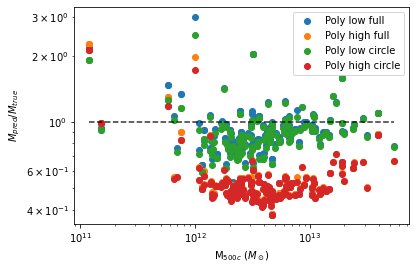

In [3]:
#load models
nnmodel = torch.load(f"{p['base_model_path']}/obs_model_e10")
nnmodel_low = torch.load(f"{p['base_model_path']}/obs_model_e10_low")
nnmodel_high = torch.load(f"{p['base_model_path']}/obs_model_e10_high")
poly_low = np.poly1d(np.load(f"{p['base_model_path']}/linear_fit_low_6.npy"))
poly_high = np.poly1d(np.load(f"{p['base_model_path']}/linear_fit_high_6.npy"))


#normalise data for NNs
data_x = np.log10(images)
std_x = np.std(data_x, axis=(0, 2, 3))
mean_x = np.mean(data_x, axis=(0, 2, 3))
data_x = (data_x - mean_x[np.newaxis, :, np.newaxis, np.newaxis]) / std_x[np.newaxis, :, np.newaxis, np.newaxis]

data_y = np.log10(masses)
std_y = np.std(data_y)
mean_y = np.mean(data_y)


predictions = np.ndarray((len(masses), 7))

#predict with NN
with torch.no_grad():
    predictions[:, 0] = 10**(nnmodel(torch.Tensor(data_x)).squeeze(1) * std_y + mean_y)
    predictions[:, 1] = 10**(nnmodel_low(torch.Tensor(data_x[:,0,:,:].reshape(len(masses), 1, 64, 64))).squeeze(1) * std_y + mean_y)
    predictions[:, 2] = 10**(nnmodel_low(torch.Tensor(data_x[:,1,:,:].reshape(len(masses), 1, 64, 64))).squeeze(1) * std_y + mean_y)





luminosities_full = np.sum(images, axis=(2, 3), dtype=np.float64)

predictions[:,3] = predict_mass_linear(luminosities_full[:,0], band="low")
predictions[:,4] = predict_mass_linear(luminosities_full[:,1], band="high")


X, Y = np.ogrid[:resolution, :resolution]
radius = resolution/2
dist_from_center = np.sqrt((X + 0.5-radius)**2+(Y+0.5-radius)**2)
circle_mask = dist_from_center <= radius

luminosities_circle = np.sum(images[:,:,circle_mask], axis=(2), dtype=np.float64)
predictions[:,5] = predict_mass_linear(luminosities_circle[:,0], band="low")
predictions[:,6] = predict_mass_linear(luminosities_circle[:,1], band="high")
# print(predict_mass(1e41))



names = ["NN 2chan", "NN low", "NN high", "Poly low full", "Poly high full", "Poly low circle", "Poly high circle"]
for i in range(3, 7):
    plt.scatter(masses, predictions[:,i]/masses, label=names[i])
plt.hlines(1.0, np.min(masses), np.max(masses), colors="black", linestyles="dashed", alpha=0.8)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M$_{500c}$ $(M_\odot)$")
plt.ylabel("$M_{pred} / M_{true}$")
plt.legend()
plt.show()



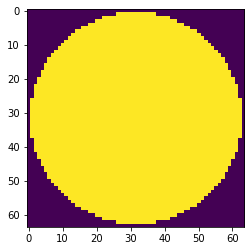

In [17]:
# circle_mask = np.zeros(resolution, resolution)
X, Y = np.ogrid[:resolution, :resolution]
radius = resolution/2
dist_from_center = np.sqrt((X + 0.5-radius)**2+(Y+0.5-radius)**2)
plt.imshow(dist_from_center<=radius)


# data exploration


In [3]:
soap_path = "halo_properties_0077.hdf5"
data = Data(p, soap_path=soap_path)

[1.00126345e+11 1.62548522e+11 2.63886813e+11 4.28402849e+11
 6.95483792e+11 1.12907210e+12 1.83297414e+12 2.97571272e+12
 4.83087349e+12 7.84260473e+12 1.27319519e+13 2.06694848e+13
 3.35555464e+13 5.44752181e+13 8.84369263e+13 1.43571521e+14
 2.33078903e+14 3.78388238e+14 6.14288367e+14 9.97256679e+14]


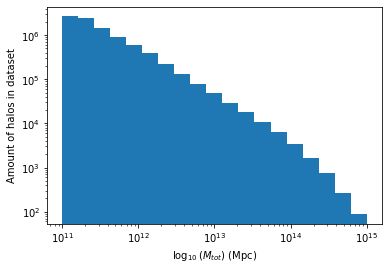

In [23]:
mass = data.soap_file[f"{p['selection_type']}/TotalMass"][:]
mass = mass[np.logical_and(np.logical_and(mass > 1e11, mass !=0), mass < 1e15)]
bins = np.logspace(np.log10(np.min(mass)), np.log10(np.max(mass)), 20)
print(bins)
ret = plt.hist(mass, bins=bins)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Amount of halos in dataset")
plt.xlabel("$\log_{10}(M_{tot})$ (Mpc)")
plt.show()

In [24]:
print(ret)

(array([2.658175e+06, 2.436279e+06, 1.443613e+06, 8.889650e+05,
       5.937730e+05, 3.860400e+05, 2.274540e+05, 1.318370e+05,
       7.770900e+04, 4.786600e+04, 2.939100e+04, 1.817200e+04,
       1.072000e+04, 6.328000e+03, 3.430000e+03, 1.670000e+03,
       7.550000e+02, 2.690000e+02, 8.800000e+01]), array([1.00126345e+11, 1.62548522e+11, 2.63886813e+11, 4.28402849e+11,
       6.95483792e+11, 1.12907210e+12, 1.83297414e+12, 2.97571272e+12,
       4.83087349e+12, 7.84260473e+12, 1.27319519e+13, 2.06694848e+13,
       3.35555464e+13, 5.44752181e+13, 8.84369263e+13, 1.43571521e+14,
       2.33078903e+14, 3.78388238e+14, 6.14288367e+14, 9.97256679e+14]), <BarContainer object of 19 artists>)
